In [15]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier,Pool
from IPython.display import display
import matplotlib.patches as patch
import matplotlib.pyplot as plt
from sklearn.svm import NuSVR
from scipy.stats import norm
from sklearn import svm
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import time
import glob
import sys
import os
import gc

In [ ]:
import pandas as pd

test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')



In [ ]:
import numpy as np
test = pd.DataFrame(test)
train = pd.DataFrame(train)

def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

In [ ]:
train, NAlist = reduce_mem_usage(train)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

In [ ]:
test, NAlist = reduce_mem_usage(test)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

In [8]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679973,-1.627628,10.715126,6.796523,11.078255,-5.065340,5.408961,16.545988,0.284159,...,3.234436,7.438449,1.927833,3.331773,17.993811,-0.142087,2.303355,8.908224,15.870864,-3.326542
std,0.300653,3.039990,4.049967,2.640832,2.043276,1.623114,7.863115,0.866585,3.418009,3.332576,...,4.559854,3.023208,1.478388,3.991934,3.135113,1.429341,5.454274,0.921603,3.010892,10.437832
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562599,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852798
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064724,4.836800
max,1.000000,20.315001,10.376800,19.353001,13.188300,16.671400,17.251600,8.447700,27.691799,10.151300,...,18.440901,16.716499,8.402400,18.281799,27.928801,4.272900,18.321501,12.000400,26.079100,28.500700


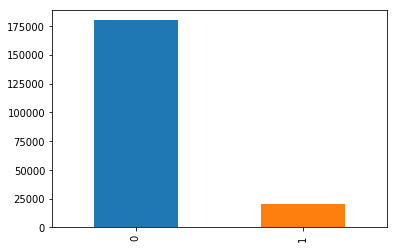

In [16]:
train['target'].value_counts().plot.bar()

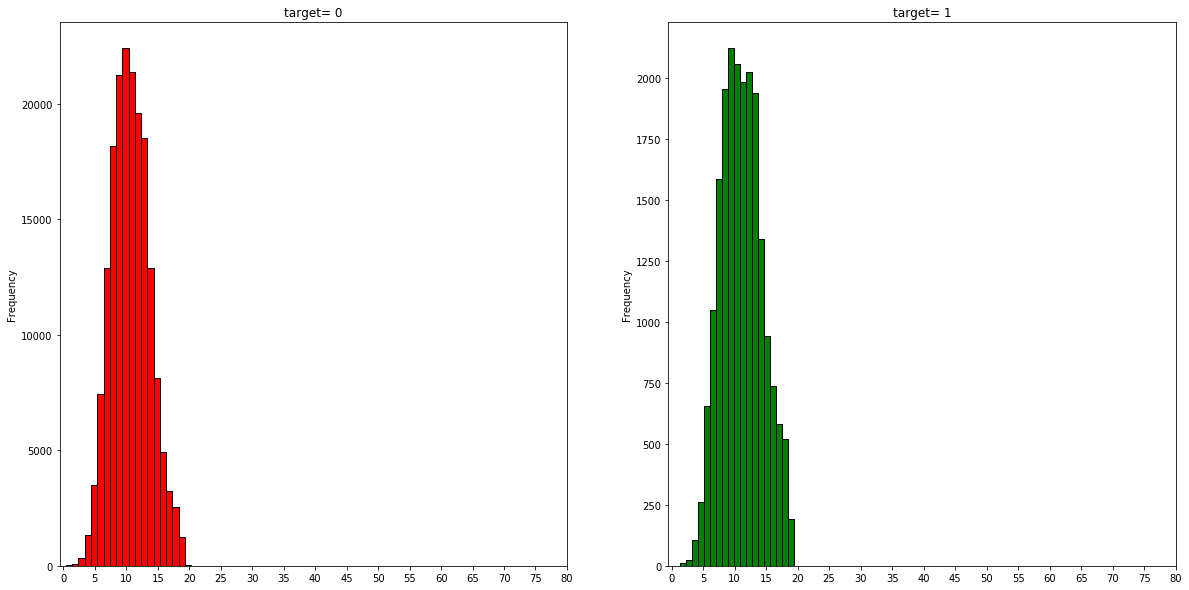

In [17]:
f,ax=plt.subplots(1,2,figsize=(20,10))
train[train['target']==0].var_0.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='red')
ax[0].set_title('target= 0')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)
train[train['target']==1].var_0.plot.hist(ax=ax[1],color='green',bins=20,edgecolor='black')
ax[1].set_title('target= 1')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)
plt.show()

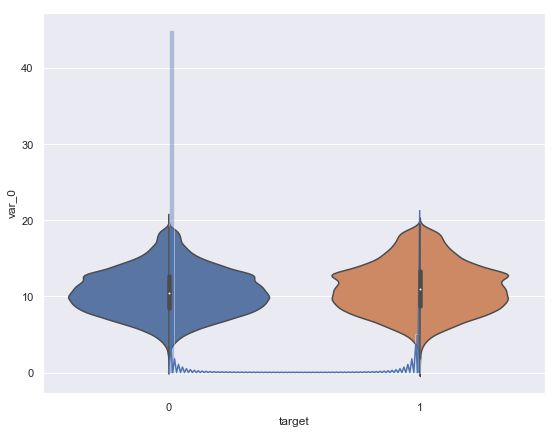

In [19]:
sns.set(rc={'figure.figsize':(9,7)})
sns.distplot(train['target']);


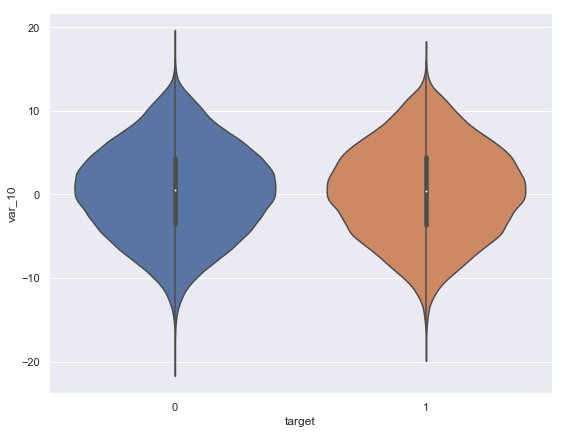

In [21]:
sns.violinplot(data=train,x="target", y="var_10")

In [27]:
def check_missing_data(df):
    flag=df.isna().sum().any()
    if flag==True:
        total = df.isnull().sum()
        percent = (df.isnull().sum())/(df.isnull().count()*100)
        output = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        data_type = []
        # written by MJ Bahmani
        for col in df.columns:
            dtype = str(df[col].dtype)
            data_type.append(dtype)
        output['Types'] = data_type
        return(np.transpose(output))
    else:
        return(False)

#check_missing_data(test)
#check_missing_data(train)

train['target'].unique()
train['target'].value_counts()


def check_balance(df,target):
    check=[]
    # written by MJ Bahmani for binary target
    print('size of data is:',df.shape[0] )
    for i in [0,1]:
        print('for target  {} ='.format(i))
        print(df[target].value_counts()[i]/df.shape[0]*100,'%')

        
check_balance(train, 'target')

print("Skewness: %f" % train['target'].skew())
print("Kurtosis: %f" % train['target'].kurt())

size of data is: 200000
for target  0 =
89.95100000000001 %
for target  1 =
10.049 %
Skewness: 2.657642
Kurtosis: 5.063112


In [28]:
cols=["target","ID_code"]
X = train.drop(cols,axis=1)
y = train["target"]

In [29]:
X_test  = test.drop("ID_code",axis=1)

In [30]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
rfc_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [32]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rfc_model, random_state=1).fit(val_X, val_y)

In [ ]:
eli5.show_weights(perm, feature_names = val_X.columns.tolist(), top=150)

In [34]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(train_X, train_y)

In [35]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]

In [39]:
from sklearn import tree
import graphviz
tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=features)

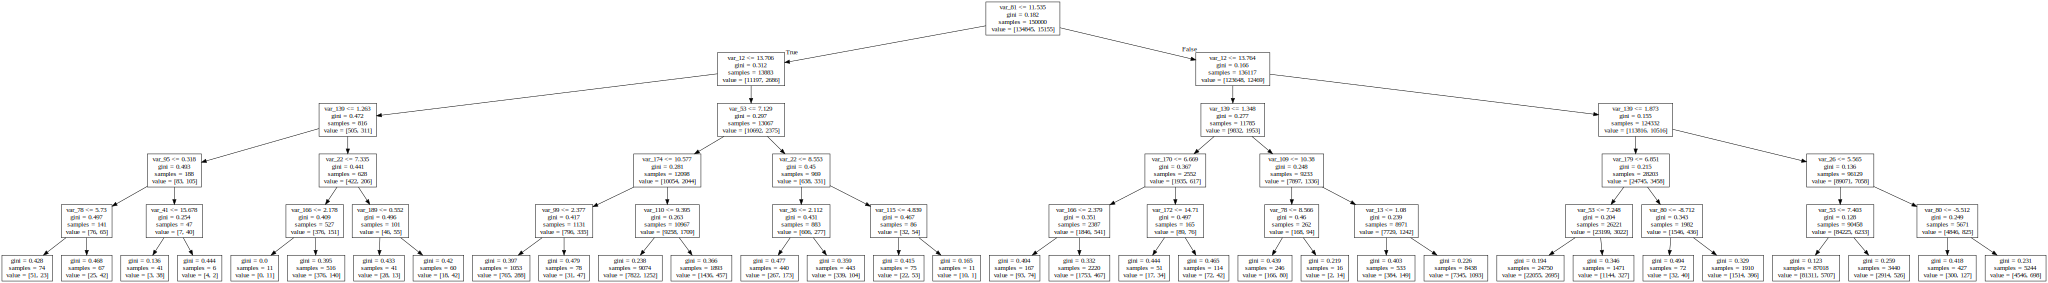

In [42]:
import os
os.environ["PATH"] += os.pathsep + 'C:/ProgramData/Anaconda3/Library/bin/graphviz/'

graphviz.Source(tree_graph)